In [3]:
import sys
sys.path.append('/home/jovyan/test_surge_models/surgeNN/')
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import os
from surgeNN.evaluation import rmse, compute_precision, compute_recall, compute_f1, add_error_metrics_to_prediction_ds
from surgeNN.preprocessing import deseasonalize_da
from scipy.stats import rankdata
import pandas as pd

2025-07-08 07:01:03.988357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-08 07:01:04.053409: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
#configure the script
tgs        = ['alicante_i_outer_harbour-alio-esp-da_mm.csv']
tgnames = ['Alicante (SP)']

qnts = np.array([.95,.98,.99,.995])

In [4]:
#Load LSTM output
lstm_datasets=[] #initialize

for tg in tgs: #load predictions of all models for each TG, stored per iteration
    lstm_datasets.append(xr.open_mfdataset('/home/jovyan/test_surge_models/results/nns/performance/lstm/lstm_3h*'+tg.replace('.csv','')+'_mse_hp1_it*',combine='nested',concat_dim='it'))
    
lstms = xr.concat(lstm_datasets,dim='tg').load() #concatenate and load into memory
lstms['tg'] = tgs

lstms = lstms.isel(time=np.arange(len(lstms.time)-10)) #codec runs slightly less far into 2017, so cut off last 10 timesteps
lstms = lstms.sel(max_timesteps_between_extremes=3)
#compute metrics for observations (it,i doesn't matter as long as all models have been run with the same n_t)
observed_thresholds = lstms.o.isel(it=0,i=0).quantile(lstms['quantile'],dim='time')
observed_stds = lstms.o.isel(it=0,i=0).std(dim='time',ddof=0)

#Load CoDEC output
codec = xr.open_dataset('/home/jovyan/test_surge_models/input/CoDEC_ERA5_at_gesla3_tgs_eu_hourly_anoms.nc') #anomalies wrt annual means
codec['surge'] = deseasonalize_da(codec['surge']) #remove seasonal cycle (as done from the predictands)
codec = codec.sel(tg=tgs) #select tide gauges
codec = codec.sel(time=lstms.time) #select at 3-hourly timesteps of neural network predictions

#compute error metrics:
codec = codec.surge.expand_dims({'split':3},axis=-1).where(lstms.o.isel(i=0,it=0))
codec = codec.to_dataset()

In [38]:
#Load observations at Alicante inner harbour
alic2 = pd.read_csv('/home/jovyan/test_surge_models/input/t_tide_3h_hourly_deseasoned_predictands/alicante_i-ali-esp-da_mm.csv')
alic2['date'] = pd.to_datetime(alic2['date'])
alic2.set_index('date').resample(str(3)+'h').fillna(method=None)
alic2.index = alic2['date']

In [39]:
time_of_test_extremes = lstms.time.where((lstms.o>observed_thresholds.sel(quantile=.99)).sel(split='test').isel(i=0,it=0,tg=0),drop=True)
time_of_val_extremes = lstms.time.where((lstms.o>observed_thresholds.sel(quantile=.99)).sel(split='val').isel(i=0,it=0,tg=0),drop=True)

In [61]:
alic2_test_extremes = alic2.loc[[k for k in alic2.date if k in time_of_test_extremes]]
alic2_val_extremes = alic2.loc[[k for k in alic2.date if k in time_of_val_extremes]]

Text(0, 0.5, 'NTR [m]')

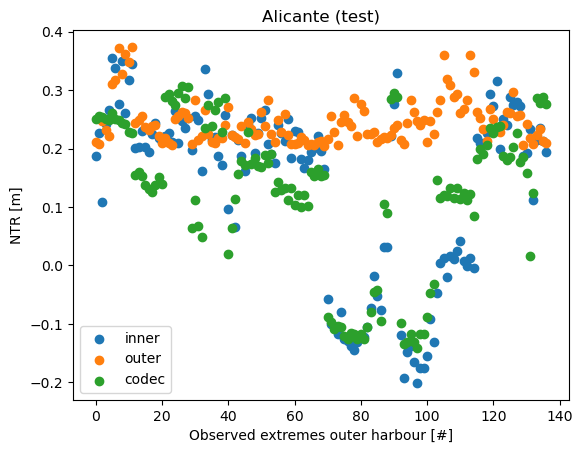

In [84]:
plt.figure()
plt.scatter(np.arange(len(alic2_test_extremes.date)),alic2_test_extremes.surge,label='inner')
plt.scatter(np.arange(len(alic2_test_extremes.date)),lstms.o.sel(split='test').isel(i=0,it=0,tg=0).sel(time=alic2_test_extremes.date.values),label='outer')
plt.scatter(np.arange(len(alic2_test_extremes.date)),codec.surge.sel(time=alic2_test_extremes.date.values).sel(split='test'),label='codec')
plt.legend()
plt.title('Alicante (test)')
plt.xlabel('Observed extremes outer harbour [#]')
plt.ylabel('NTR [m]')

Text(0, 0.5, 'NTR [m]')

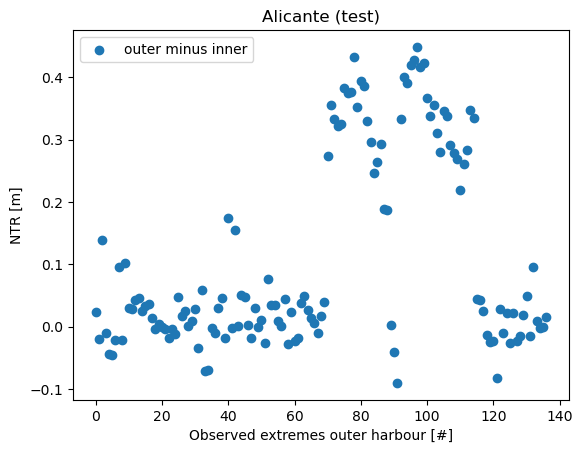

In [85]:
plt.figure()
plt.scatter(np.arange(len(alic2_test_extremes.date)),lstms.o.sel(split='test').isel(i=0,it=0,tg=0).sel(time=alic2_test_extremes.date.values)-alic2_test_extremes.surge,label='outer minus inner')

plt.legend()
plt.title('Alicante (test)')
plt.xlabel('Observed extremes outer harbour [#]')
plt.ylabel('NTR [m]')

Text(0, 0.5, 'NTR [m]')

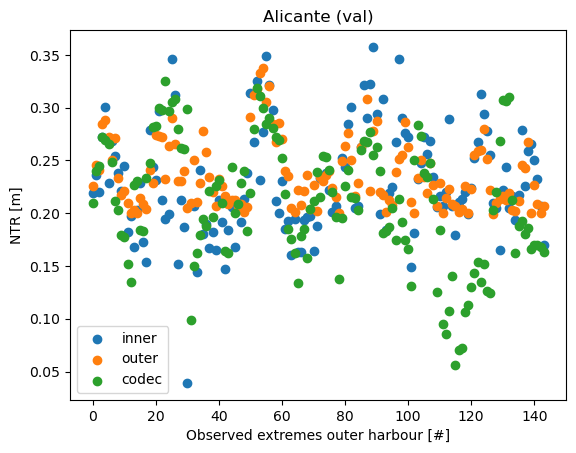

In [83]:
plt.figure()
plt.scatter(np.arange(len(alic2_val_extremes.date)),alic2_val_extremes.surge,label='inner')
plt.scatter(np.arange(len(alic2_val_extremes.date)),lstms.o.sel(split='val').isel(i=0,it=0,tg=0).sel(time=alic2_val_extremes.date.values),label='outer')
plt.scatter(np.arange(len(alic2_val_extremes.date)),codec.surge.sel(time=alic2_val_extremes.date.values).sel(split='val'),label='codec')
plt.legend()
plt.title('Alicante (val)')
plt.xlabel('Observed extremes outer harbour [#]')
plt.ylabel('NTR [m]')


Text(0, 0.5, 'NTR [m]')

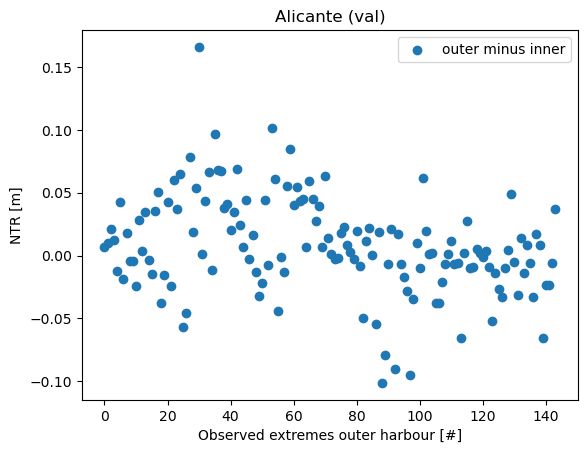

In [86]:
plt.figure()
plt.scatter(np.arange(len(alic2_val_extremes.date)),lstms.o.sel(split='val').isel(i=0,it=0,tg=0).sel(time=alic2_val_extremes.date.values)-alic2_val_extremes.surge,label='outer minus inner')

plt.legend()
plt.title('Alicante (val)')
plt.xlabel('Observed extremes outer harbour [#]')
plt.ylabel('NTR [m]')
